In [1]:
import torch.nn as nn
import torch
import numpy as np
import os
import gc
import matplotlib.pyplot as plt
import sys
from timm.models.vision_transformer import Block
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel
import time
import timm.optim.optim_factory as optim_factory
import datetime
import copy
from scipy.interpolate import interp1d
from torch.utils.data import Dataset
from torch import inf
import mne
from scipy.signal import spectrogram, istft
import numpy as np
from scipy.signal import butter, filtfilt
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import cv2
import numpy as np


In [2]:
pip install torch torchvision opencv-python -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torch-geometric -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch_geometric.loader import DataLoader


In [5]:
!pwd

/kaggle/working


In [6]:
cd ../input

/kaggle/input


In [7]:
!ls


block_splits_by_image_all.pth	  eeg_5_95_std.pth
block_splits_by_image_single.pth  imageNet_images


In [8]:
#main_path = "/kaggle/working/generated_images/"
process_file_pth = "eeg_5_95_std.pth"
split_path = "block_splits_by_image_single.pth"
imgNet_path = "imageNet_images/imageNet_images"

In [9]:
try:
    loaded_data_new = torch.load(process_file_pth)
except FileNotFoundError:
    print(f"The file {split_path} does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")

splits = loaded_data_new.keys()
print(splits)

dict_keys(['dataset', 'labels', 'images'])


In [10]:
dataset_new = loaded_data_new["dataset"]
labels_new = loaded_data_new["labels"]
images_new = loaded_data_new["images"]

dataset_new = np.array(dataset_new)
labels_new = np.array(labels_new)
images_new = np.array(images_new)

dataset_image = [dataset_new[i]["image"] for i in range(len(dataset_new))]
dataset_label = [dataset_new[i]["label"] for i in range(len(dataset_new))]
dataset_eeg = [dataset_new[i]["eeg"] for i in range(len(dataset_new))]
dataset_subject = [dataset_new[i]["subject"] for i in range(len(dataset_new))]

In [23]:
np.unique(dataset_image, return_counts=True)

(array([   0,    1,    2, ..., 1993, 1994, 1995]),
 array([6, 6, 6, ..., 6, 6, 6]))

In [11]:
dataset_corresponding_image = []
for index, value in enumerate(dataset_image):
    dataset_corresponding_image.append(images_new[value])
dataset_corresponding_image = np.array(dataset_corresponding_image)

In [12]:
image_paths = [
    imgNet_path +"/"+ img.split("_")[0] + "/" + str(img) + ".JPEG" for img in dataset_corresponding_image]

In [13]:
eeg_list = [eeg[:,20:470] for eeg in dataset_eeg]
print(dataset_eeg[0].shape)

torch.Size([128, 500])


In [14]:
channels = ['Fp1',
'Fp2',
'F7',
'F3',
'Fz',
'F4',
'F8',
'FC5',
'FC1',
'FC2',
'FC6',
'T7',
'C3',
'Cz',
'C4',
'T8',
'TP9',
'CP5',
'CP1',
'CP2',
'CP6',
'TP10',
'P7',
'P3',
'Pz',
'P4',
'P8',
'PO9',
'O1',
'Oz',
'O2',
'PO10',
'AF7',
'AF3',
'AF4',
'AF8',
'F5',
'F1',
'F2',
'F6',
'FT9',
'FT7',
'FC3',
'FC4',
'FT8',
'FT10',
'C5',
'C1',
'C2',
'C6',
'TP7',
'CP3',
'CPz',
'CP4',
'TP8',
'P5',
'P1',
'P2',
'P6',
'PO7',
'PO3',
'POz',
'PO4',
'PO8',
'Fpz',
'F9',
'AFF5h',
'AFF1h',
'AFF2h',
'AFF6h',
'F10',
'FTT9h',
'FTT7h',
'FCC5h',
'FCC3h',
'FCC1h',
'FCC2h',
'FCC4h',
'FCC6h',
'FTT8h',
'FTT10h',
'TPP9h',
'TPP7h',
'CPP5h',
'CPP3h',
'CPP1h',
'CPP2h',
'CPP4h',
'CPP6h',
'TPP8h',
'TPP10h',
'POO9h',
'POO1',
'POO2',
'POO10h',
'Iz',
'AFp1',
'AFp2',
'FFT9h',
'FFT7h',
'FFC5h',
'FFC3h',
'FFC1h',
'FFC2h',
'FFC4h',
'FFC6h',
'FFT8h',
'FFT10h',
'TTP7h',
'CCP5h',
'CCP3h',
'CCP1h',
'CCP2h',
'CCP4h',
'CCP6h',
'TTP8h',
'P9',
'PPO9h',
'PPO5h',
'PPO1h',
'PPO2h',
'PPO6h',
'PPO10h',
'P10',
'I1',
'OI1h',
'OI2h',
'I2'] 

# Get the indices of the occipital channels
occipital_indices = []
for i,ch in enumerate(channels):
    if "O" in ch:
        occipital_indices.append(i)


In [15]:
len(occipital_indices)

22

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T
import cv2
import numpy as np

# Load MiDaS model
midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS')
midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms').default_transform

# Set the model to evaluation mode
midas.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
midas.to(device)


In [17]:
def generate_depth_map(image_path):
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            return None  # Image not found or corrupted

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Transform image
        input_batch = midas_transforms(img_rgb).to(device)

        # Predict and generate depth map
        with torch.no_grad():
            prediction = midas(input_batch)

            # Resize the prediction to the original image size
            prediction = F.interpolate(
                prediction.unsqueeze(1),
                size=img_rgb.shape[:2],
                mode='bicubic',
                align_corners=False
            ).squeeze()

        # Convert depth map to numpy array and normalize
        depth_map = prediction.cpu().numpy()
        depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

        # Resize the depth map to 128x128
        depth_map_resized = cv2.resize(depth_map, (128, 128), interpolation=cv2.INTER_AREA)

        return depth_map_resized
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


In [18]:
'''def generate_fully_connected_edge_index(num_nodes):
    row = np.repeat(np.arange(num_nodes), num_nodes)
    col = np.tile(np.arange(num_nodes), num_nodes)
    edge_index = np.stack([row, col], axis=0)
    return torch.tensor(edge_index, dtype=torch.long)

class EEGDepthDataset(Dataset):
    def __init__(self, eegs, image_paths, transform=None):
        self.eegs = eegs
        self.image_paths = image_paths
        self.transform = transform
        self.skip_path = "/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images/n03452741/n03452741_17620.JPEG"

    def __len__(self):
        return len(self.eegs)

    def __getitem__(self, idx):
        eeg = self.eegs[idx]
        img_path = self.image_paths[idx]

        if img_path == self.skip_path:
            print(f"Skipping predefined corrupted image: {img_path}")
            return None

        try:
            # Get occipital channels
            occipital_eeg = eeg[occipital_indices, :].clone().detach()

            # Generate and resize depth map
            depth_map = generate_depth_map(img_path)
            depth_map = torch.tensor(depth_map, dtype=torch.float32).unsqueeze(0).clone().detach()  # Add channel dimension

            x = occipital_eeg.clone().detach().float()
            y = depth_map

            # Create graph data object
            edge_index = generate_fully_connected_edge_index(x.shape[0])
            data = Data(x=x, edge_index=edge_index, y=y)

            # Print shapes for debugging
           #print(f"x shape: {x.shape}, edge_index shape: {edge_index.shape}, y shape: {y.shape}")

            return data

        except Exception as e:
            print(f"Skipping corrupted image: {img_path}, Error: {e}")
            return None


def filter_none_entries(dataset):
    return [item for item in dataset if item is not None]

eegs_train, eegs_val, imgs_train, imgs_val = train_test_split(eeg_list, image_paths, test_size=0.2, random_state=42)

train_dataset = EEGDepthDataset(eegs_train, imgs_train)
val_dataset = EEGDepthDataset(eegs_val, imgs_val)

train_data = filter_none_entries([train_dataset[i] for i in range(len(train_dataset))])
val_data = filter_none_entries([val_dataset[i] for i in range(len(val_dataset))])'''

'def generate_fully_connected_edge_index(num_nodes):\n    row = np.repeat(np.arange(num_nodes), num_nodes)\n    col = np.tile(np.arange(num_nodes), num_nodes)\n    edge_index = np.stack([row, col], axis=0)\n    return torch.tensor(edge_index, dtype=torch.long)\n\nclass EEGDepthDataset(Dataset):\n    def __init__(self, eegs, image_paths, transform=None):\n        self.eegs = eegs\n        self.image_paths = image_paths\n        self.transform = transform\n        self.skip_path = "/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images/n03452741/n03452741_17620.JPEG"\n\n    def __len__(self):\n        return len(self.eegs)\n\n    def __getitem__(self, idx):\n        eeg = self.eegs[idx]\n        img_path = self.image_paths[idx]\n\n        if img_path == self.skip_path:\n            print(f"Skipping predefined corrupted image: {img_path}")\n            return None\n\n        try:\n            # Get occipital channels\n            occipital_eeg = eeg[occipital_indices, :].clon

In [19]:
'''torch.save(train_data, '../working/train_data.pth')
torch.save(val_data, '../working/val_data.pth')'''

NameError: name 'train_data' is not defined

In [25]:
# Load data
train_data = torch.load('../working/train_data.pth')
val_data = torch.load('../working/val_data.pth')

# Check the shape of one batch
for data in train_data:
    print(f"Data x shape: {data.x.shape}, Data edge_index shape: {data.edge_index.shape}, Data y shape: {data.y.shape}")
    break

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


Data x shape: torch.Size([22, 450]), Data edge_index shape: torch.Size([2, 484]), Data y shape: torch.Size([1, 128, 128])


In [26]:
for item in train_loader:
    print(type(item[0]))
    break

<class 'torch_geometric.data.data.Data'>


In [48]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader

# ImprovedGCNN Model Definition
class ImprovedGCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ImprovedGCNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm2 = torch.nn.BatchNorm1d(hidden_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #print(f'Inp_x: {x.shape}')
        x = self.conv1(x, edge_index)
        #print(f'out_conv1: {x.shape}')
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)
        #print(f'Out_Block1: {x.shape}')

        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)  # global mean pooling

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        # Reshape output to match the target shape
        x = x.view(-1, 128, 128)

        return x

class ImprovedGCNN_11(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ImprovedGCNN_11, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.fc2 = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm2 = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm3 = torch.nn.BatchNorm1d(hidden_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # First block
        x1 = self.conv1(x, edge_index)
        x1 = self.batch_norm1(x1)
        x1 = F.relu(x1)
        x1 = self.dropout(x1)
        
        # Second block with residual connection
        x2 = self.conv2(x1, edge_index)
        x2 = self.batch_norm2(x2)
        x2 = F.relu(x2)
        x2 = self.dropout(x2)
        
        x2 += x1  # Residual connection

        # Third block with residual connection
        x3 = self.conv3(x2, edge_index)
        x3 = self.batch_norm3(x3)
        x3 = F.relu(x3)
        x3 = self.dropout(x3)
        
        x3 += x2  # Residual connection

        x4 = self.conv4(x3, edge_index)
        x4 = F.relu(x4)
        x4 = global_mean_pool(x4, batch)  # global mean pooling

        x4 = self.fc1(x4)
        x4 = F.relu(x4)
        x4 = self.dropout(x4)
        x4 = self.fc2(x4)

        # Reshape output to match the target shape
        x4 = x4.view(-1, 128, 128)

        return x4    
    
    
    
class SimpleGCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGCNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc1 = torch.nn.Linear(hidden_channels, out_channels)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        #print(f"Input x shape: {x.shape}, edge_index shape: {edge_index.shape}")
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        
        x = self.fc1(x)
        x = x.view(-1, 128, 128)
        #print(f"Output shape: {x.shape}")
        return x

# Define the HybridGCN_CNN model
class HybridGCN_CNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(HybridGCN_CNN, self).__init__()
        # GCN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_channels)
        self.batch_norm2 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout = torch.nn.Dropout(0.5)
        
        # CNN layers
        self.conv_cnn1 = torch.nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv_cnn2 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv_cnn3 = torch.nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv_transpose1 = torch.nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1)
        self.conv_transpose2 = torch.nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1)
        self.conv_transpose3 = torch.nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1)
        self.fc1 = torch.nn.Linear(hidden_channels, 256*32*32)  # Adjust to match the size before CNN layers
        
        self.relu = torch.nn.ReLU()

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        # GCN forward pass
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.relu(x)
        x = global_mean_pool(x, batch)
        
        x = self.fc1(x)
        x = x.view(-1, 256, 32, 32)  # Reshape to match the input size for CNN layers

        # CNN forward pass
        x = self.conv_cnn1(x)
        x = self.relu(x)
        x = self.conv_cnn2(x)
        x = self.relu(x)
        x = self.conv_cnn3(x)
        x = self.relu(x)
        
        x = self.conv_transpose1(x)
        x = self.relu(x)
        x = self.conv_transpose2(x)
        x = self.relu(x)
        x = self.conv_transpose3(x)
        x = x.view(-1, 128, 128)

        return x

class ImprovedGCNN_11_skip(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, hidden_channels_1, out_channels):
        super(ImprovedGCNN_11_skip, self).__init__()
        self.conv1 = GCNConv(in_channels, 450)
        self.conv2 = GCNConv(450, 250)
        self.conv2_1x1 = GCNConv(250, 120)  # 1x1 conv to match channels for residual connection
        self.conv3 = GCNConv(250, 120)
        self.conv4 = GCNConv(120, 50)
        self.conv5 = GCNConv(50, 40)
        self.fc1 = torch.nn.Linear(40, 3000)
        #self.fc2 = torch.nn.Linear(3000, 3000)
        self.fc3 = torch.nn.Linear(3000, 128*128)  # FC layer to reshape output
        self.conv6 = torch.nn.Conv2d(1, 1, 3, padding=1)  # Conv layer to further process image
        self.dropout = torch.nn.Dropout(0.2)
        self.batch_norm1 = torch.nn.BatchNorm1d(450)
        self.batch_norm2 = torch.nn.BatchNorm1d(250)
        self.batch_norm3 = torch.nn.BatchNorm1d(120)
        self.batch_norm4 = torch.nn.BatchNorm1d(50)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # First block
        x1 = self.conv1(x, edge_index)
        x1 = self.batch_norm1(x1)
        x1 = F.relu(x1)
        
        # Second block
        x2 = self.conv2(x1, edge_index)
        x2 = self.batch_norm2(x2)
        x2 = F.relu(x2)
        x2 = self.dropout(x2)
        #x2_res = self.conv2_1x1(x2, edge_index)  # 1x1 conv for residual connection

        # Third block with residual connection
        x3 = self.conv3(x2, edge_index)
        x3 = self.batch_norm3(x3)
        x3 = F.relu(x3)
        #x3 += x2  # Residual connection with adjusted channels

        # Fourth block
        x4 = self.conv4(x3, edge_index)
        x4 = self.batch_norm4(x4)
        x4 = F.relu(x4)

        # Fifth block
        x5 = self.conv5(x4, edge_index)
        x5 = F.relu(x5)
        x5 = global_mean_pool(x5, batch)  # global mean pooling

        x5 = self.fc1(x5)
        x5 = F.relu(x5)
        x5 = self.dropout(x5)
        #x5 = self.fc2(x5)
        #x5 = F.relu(x5)
        x5 = self.fc3(x5)  # Reshape output to 128*128

        x5 = x5.view(-1, 1, 128, 128)  # Reshape to (batch_size, channels, height, width)
        x5 = self.conv6(x5)  # Conv layer to further process image
        x5 = torch.sigmoid(x5)  # Apply sigmoid to get pixel values in range [0, 1]

        return x5

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model_1 = ImprovedGCNN(in_channels=450, hidden_channels=300, out_channels=128*128).to(device)
model = ImprovedGCNN_11_skip(in_channels=450, hidden_channels=3000, hidden_channels_1 = 3000, out_channels=128*128).to(device)
#model_1 = ImprovedGCNN_11(in_channels=450, hidden_channels=100, out_channels=128*128).to(device)
#model_1 = SimpleGCNN(in_channels=450, hidden_channels=300, out_channels=128*128).to(device)
#model_1 = HybridGCN_CNN(in_channels=450, hidden_channels=100, out_channels=128*128).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-6)
criterion = torch.nn.MSELoss()

#if path yes
#model.load_state_dict(torch.load('best_model.pth'))

In [50]:
#!pip install piq -q

In [51]:
criterion = torch.nn.MSELoss()

#import piq
#def ssim_loss(output, target):
#    return 1 - piq.ssim(output, target, data_range=1.0)  # Assuming the images are normalized to [0, 1]
#criterion = ssim_loss

#from torchvision.models import vgg16
#from torchvision import transforms
#vgg = vgg16(pretrained=True).features[:16].eval().to(device)
# Freeze VGG model
#for param in vgg.parameters():
#    param.requires_grad = False
#def perceptual_loss(output, target):
#    output_features = vgg(output)
#    target_features = vgg(target)
#    return F.mse_loss(output_features, target_features)
#criterion = perceptual_loss


# Example: using perceptual loss
'''from torchvision.models import vgg16
vgg = vgg16(pretrained=True).features[:16].eval().to(device)
for param in vgg.parameters():
    param.requires_grad = False

def combined_loss(output, target):
    mse_loss = F.mse_loss(output, target)
    output_features = vgg(output.unsqueeze(1))
    target_features = vgg(target.unsqueeze(1))
    perceptual_loss = F.mse_loss(output_features, target_features)
    return mse_loss + 0.1 * perceptual_loss

criterion = combined_loss'''

'from torchvision.models import vgg16\nvgg = vgg16(pretrained=True).features[:16].eval().to(device)\nfor param in vgg.parameters():\n    param.requires_grad = False\n\ndef combined_loss(output, target):\n    mse_loss = F.mse_loss(output, target)\n    output_features = vgg(output.unsqueeze(1))\n    target_features = vgg(target.unsqueeze(1))\n    perceptual_loss = F.mse_loss(output_features, target_features)\n    return mse_loss + 0.1 * perceptual_loss\n\ncriterion = combined_loss'

In [52]:
#!pip install torchsummary -q

In [53]:
print(model)
#print(model_1)

ImprovedGCNN_11_skip(
  (conv1): GCNConv(450, 450)
  (conv2): GCNConv(450, 250)
  (conv2_1x1): GCNConv(250, 120)
  (conv3): GCNConv(250, 120)
  (conv4): GCNConv(120, 50)
  (conv5): GCNConv(50, 40)
  (fc1): Linear(in_features=40, out_features=3000, bias=True)
  (fc3): Linear(in_features=3000, out_features=16384, bias=True)
  (conv6): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm1): BatchNorm1d(450, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [54]:
# Training and Evaluation Functions
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    total_loss = 0
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False, disable=True):
        if data is None:
            continue
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        output = output.squeeze(1)  # Remove the channel dimension
        #print(f"Target shape: {data.y.shape}")
        #print(f"Output shape: {output.shape}")
        loss = criterion(output, data.y.view(-1, 128, 128))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in tqdm(val_loader, desc="Evaluating", leave=False, disable=True):
            if data is None:
                continue
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.y.view(-1, 128, 128))
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [55]:
# Track training and validation losses
train_losses = []
val_losses = []


num_epochs = 500
plot_interval = 10  # Plot every 'plot_interval' epochs
best_val_loss = float('inf')
patience_counter = 0


In [56]:
def plot_output_vs_target(outputs, targets, epoch, base = 1):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title(f'Target Epoch {epoch + base}')
    plt.imshow(np.squeeze(targets), cmap='viridis')
    plt.subplot(1, 2, 2)
    plt.title(f'Output Epoch {epoch + base}')
    plt.imshow(np.squeeze(outputs), cmap='viridis')
    plt.show()

In [57]:
def test_model(model, val_loader, device):
    model.eval()
    outputs = []
    targets = []
    with torch.no_grad():
        for data in val_loader:
            if data is None:
                continue
            data = data.to(device)
            output = model(data)
            outputs.append(output.cpu().numpy())
            targets.append(data.y.cpu().numpy())
    return outputs, targets

Training:   0%|          | 0/500 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 128, 128])) that is different to the input size (torch.Size([32, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24, 128, 128])) that is different to the input size (torch.Size([24, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training:   2%|▏         | 10/500 [01:16<1:02:00,  7.59s/it, Train Loss=0.0579, Val Loss=0.0595]

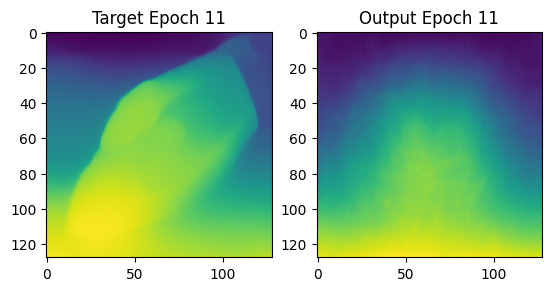

Training:   4%|▍         | 20/500 [02:36<1:00:52,  7.61s/it, Train Loss=0.0559, Val Loss=0.0603]

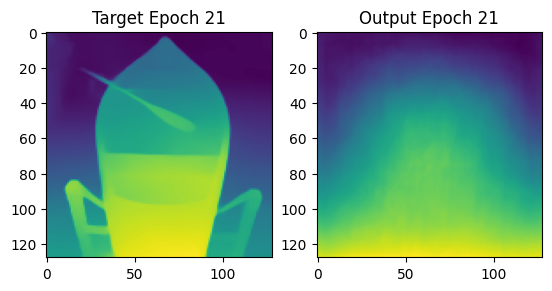

Training:   6%|▌         | 30/500 [03:56<59:26,  7.59s/it, Train Loss=0.0516, Val Loss=0.0637]  

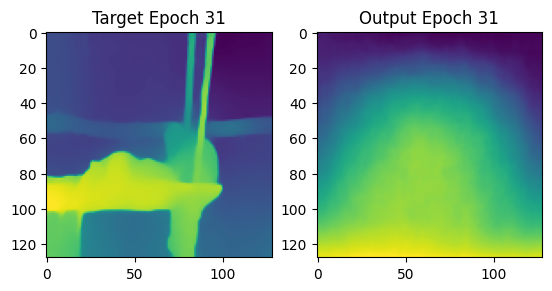

Training:   8%|▊         | 40/500 [05:15<58:20,  7.61s/it, Train Loss=0.0478, Val Loss=0.0659]  

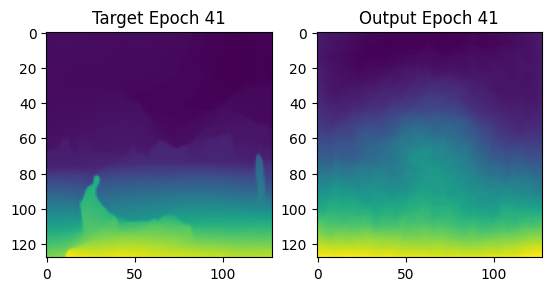

Training:  10%|█         | 50/500 [06:34<57:06,  7.62s/it, Train Loss=0.0456, Val Loss=0.0679]  

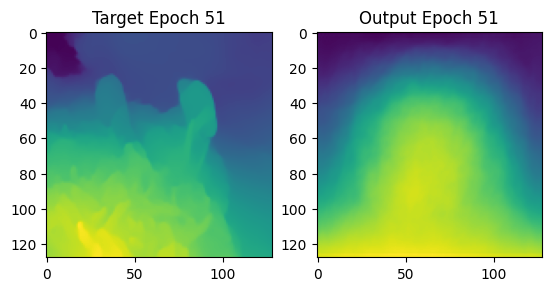

Training:  12%|█▏        | 60/500 [07:54<55:35,  7.58s/it, Train Loss=0.0436, Val Loss=0.0678]  

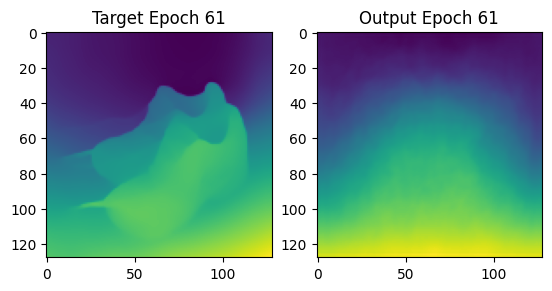

Training:  14%|█▍        | 70/500 [09:13<54:37,  7.62s/it, Train Loss=0.0423, Val Loss=0.0709]  

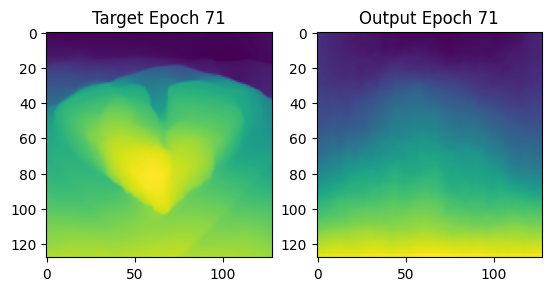

Training:  16%|█▌        | 80/500 [10:33<53:16,  7.61s/it, Train Loss=0.0415, Val Loss=0.0708] 

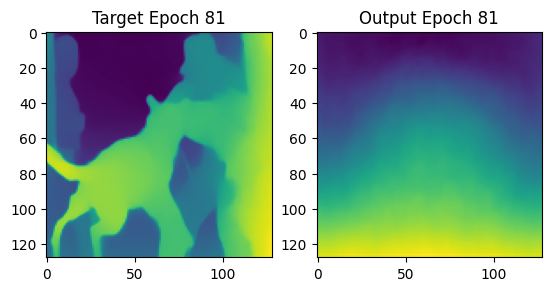

Training:  18%|█▊        | 90/500 [11:52<52:02,  7.62s/it, Train Loss=0.0408, Val Loss=0.0699]  

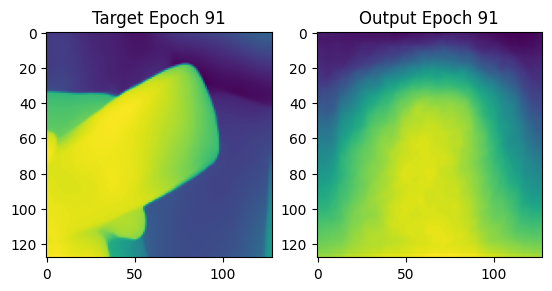

Training:  20%|██        | 100/500 [13:12<51:29,  7.72s/it, Train Loss=0.0403, Val Loss=0.0704]

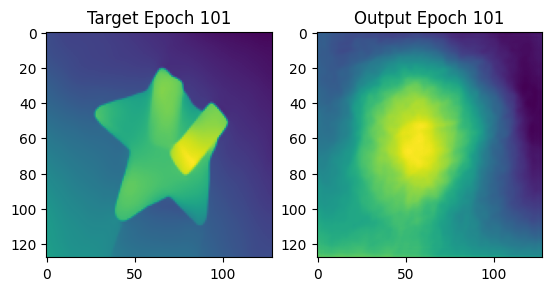

Training:  22%|██▏       | 110/500 [14:33<50:27,  7.76s/it, Train Loss=0.0395, Val Loss=0.0703]

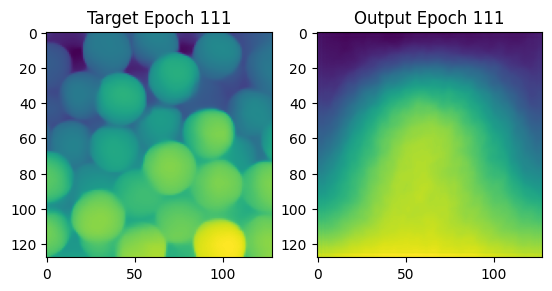

Training:  24%|██▍       | 120/500 [15:54<49:10,  7.76s/it, Train Loss=0.039, Val Loss=0.0702] 

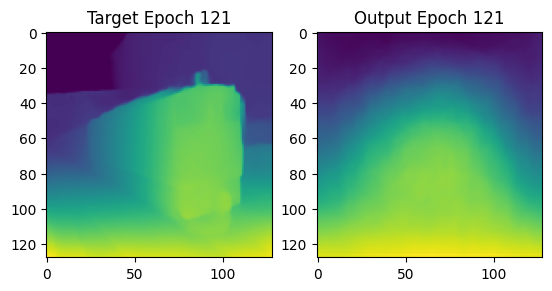

Training:  26%|██▌       | 130/500 [17:14<46:57,  7.62s/it, Train Loss=0.0386, Val Loss=0.0714]

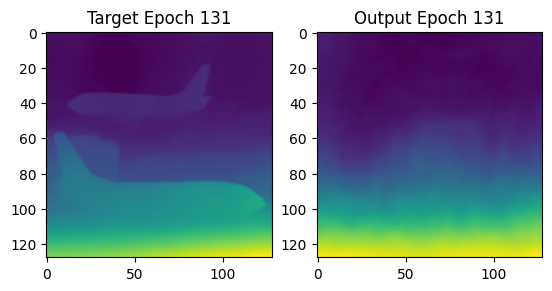

Training:  28%|██▊       | 140/500 [18:35<46:35,  7.76s/it, Train Loss=0.0378, Val Loss=0.0708]

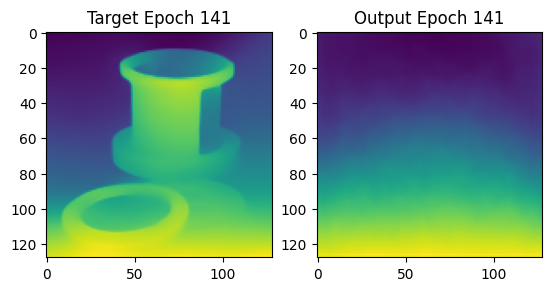

Training:  30%|███       | 150/500 [19:56<45:06,  7.73s/it, Train Loss=0.0371, Val Loss=0.073] 

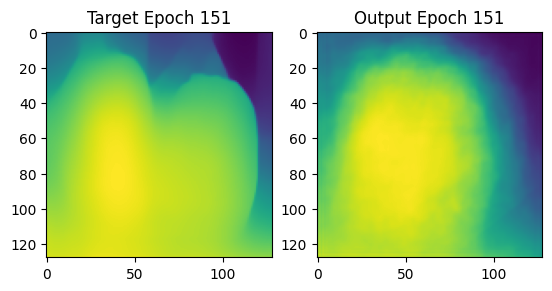

Training:  32%|███▏      | 160/500 [21:17<43:52,  7.74s/it, Train Loss=0.037, Val Loss=0.0716] 

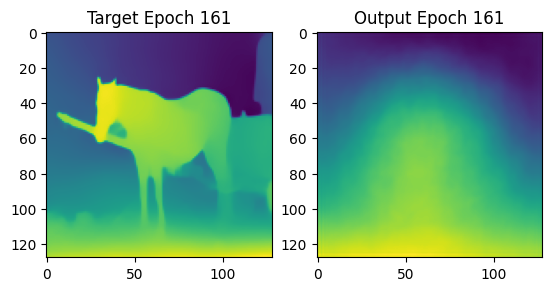

Training:  34%|███▍      | 170/500 [22:37<42:19,  7.70s/it, Train Loss=0.0364, Val Loss=0.0706]

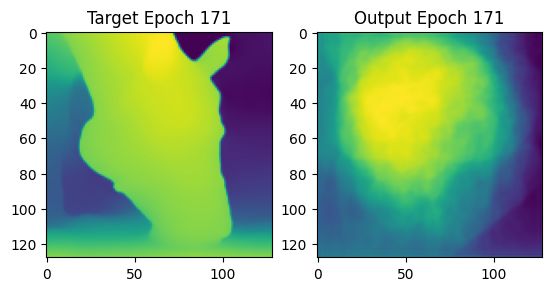

Training:  36%|███▌      | 180/500 [23:58<41:39,  7.81s/it, Train Loss=0.0359, Val Loss=0.072] 

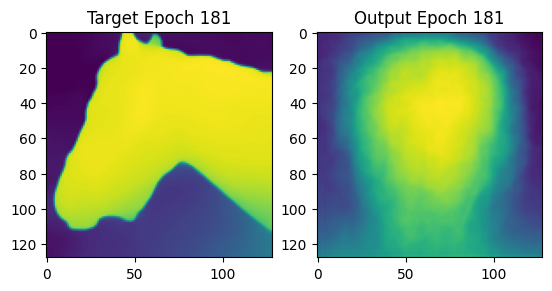

Training:  38%|███▊      | 190/500 [25:20<40:26,  7.83s/it, Train Loss=0.0354, Val Loss=0.0722]

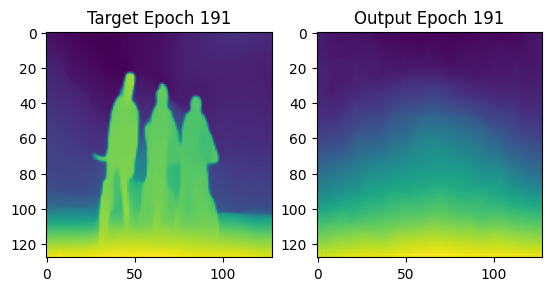

Training:  40%|████      | 200/500 [26:42<39:13,  7.85s/it, Train Loss=0.035, Val Loss=0.0734] 

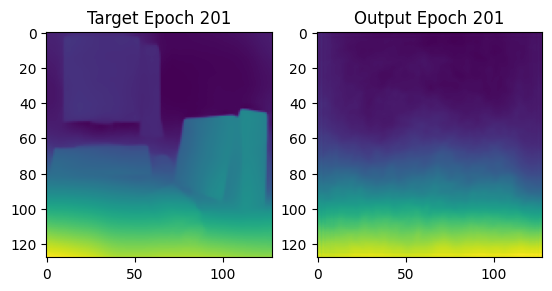

Training:  42%|████▏     | 210/500 [28:03<37:29,  7.76s/it, Train Loss=0.0347, Val Loss=0.0738]

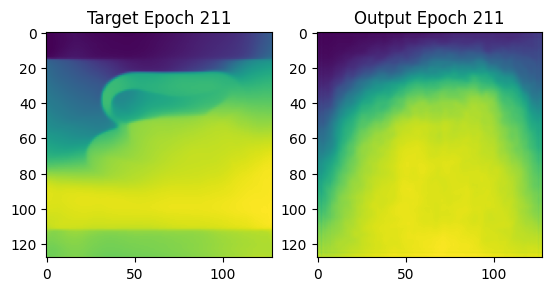

Training:  44%|████▍     | 220/500 [29:23<35:54,  7.70s/it, Train Loss=0.034, Val Loss=0.0732] 

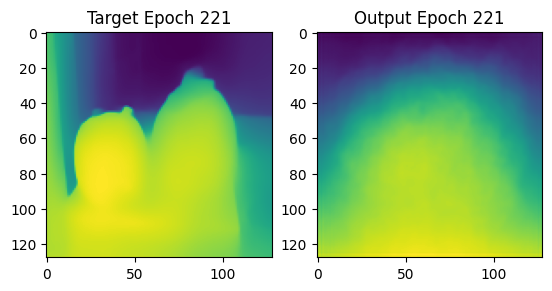

Training:  46%|████▌     | 230/500 [30:44<34:39,  7.70s/it, Train Loss=0.0341, Val Loss=0.0726]

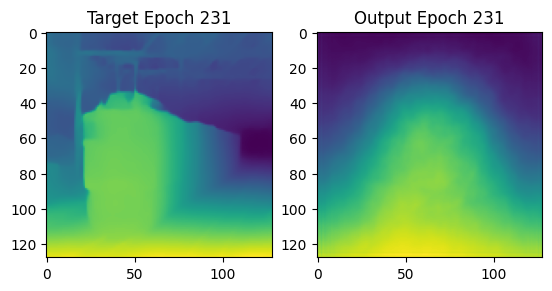

Training:  48%|████▊     | 240/500 [32:04<33:24,  7.71s/it, Train Loss=0.0338, Val Loss=0.0735]

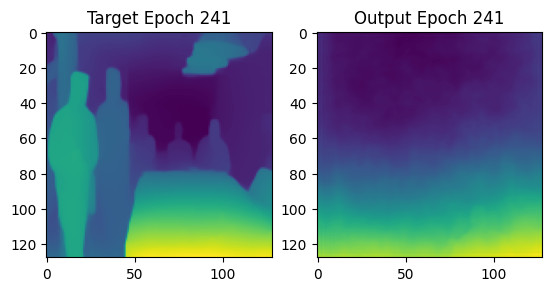

Training:  50%|█████     | 250/500 [33:25<32:27,  7.79s/it, Train Loss=0.0335, Val Loss=0.0735]

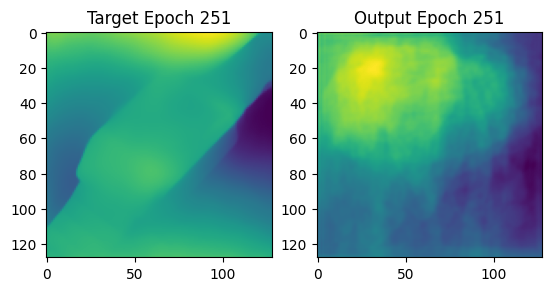

Training:  52%|█████▏    | 260/500 [34:47<31:15,  7.81s/it, Train Loss=0.0331, Val Loss=0.0735]

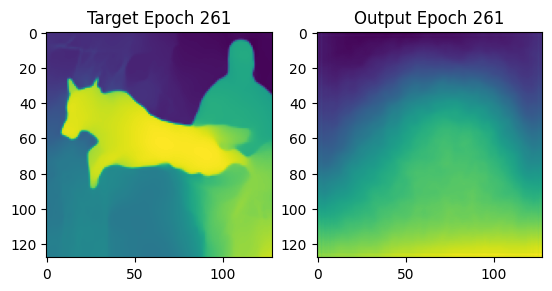

Training:  54%|█████▍    | 270/500 [36:08<29:54,  7.80s/it, Train Loss=0.033, Val Loss=0.073]  

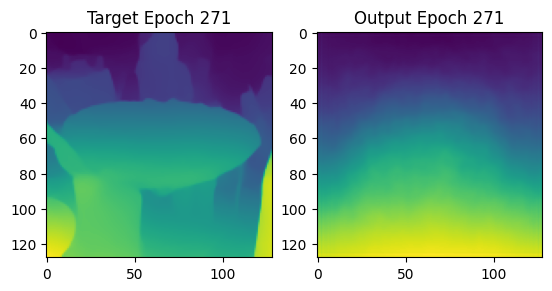

Training:  56%|█████▌    | 280/500 [37:29<28:38,  7.81s/it, Train Loss=0.0326, Val Loss=0.0728]

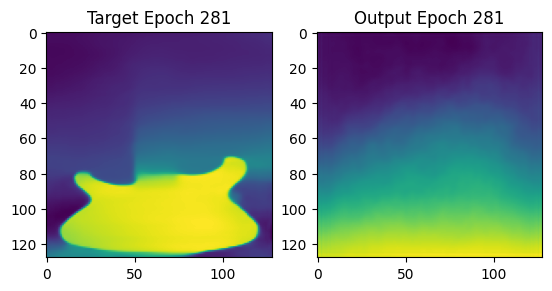

Training:  58%|█████▊    | 290/500 [38:50<27:17,  7.80s/it, Train Loss=0.0327, Val Loss=0.0726]

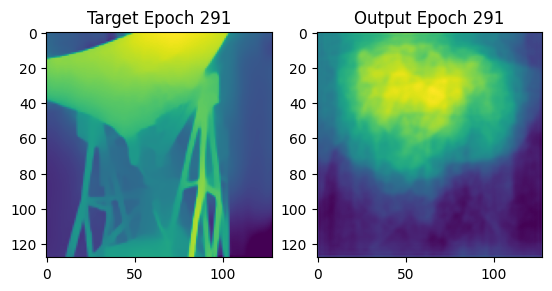

Training:  60%|██████    | 300/500 [40:12<26:03,  7.82s/it, Train Loss=0.0324, Val Loss=0.0737]

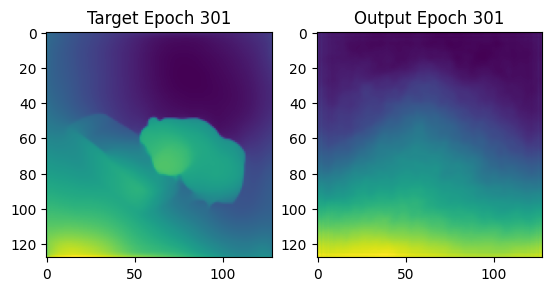

Training:  60%|██████    | 302/500 [40:31<28:17,  8.57s/it, Train Loss=0.032, Val Loss=0.0733] 

In [ ]:
with tqdm(total=num_epochs, desc="Training") as epoch_pbar:
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device, epoch)
        val_loss = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Update progress bar and print epoch results
        epoch_pbar.set_postfix({'Train Loss': train_loss, 'Val Loss': val_loss})
        epoch_pbar.update(1)  # Update by one epoch

        # Plot outputs vs targets periodically
        if (epoch + 1) % plot_interval == 0:
            outputs, targets = test_model(model, train_loader, device)
            tag = np.random.randint(0, 20)
            ind = np.random.randint(0, 50)
            plot_output_vs_target(outputs[ind][tag], targets[ind][tag], epoch=epoch+1)
            
torch.save(model.state_dict(), '../working/best_model_1_wtDecay_54.pth')

In [ ]:
'''# Plot training and validation loss
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()'''

In [ ]:
#Test script
def test_model(model, val_loader, device):
    model.eval()
    outputs = []
    targets = []
    with torch.no_grad():
        for data in val_loader:
            if data is None:
                continue
            data = data.to(device)
            output = model(data)
            outputs.append(output.cpu().numpy())
            targets.append(data.y.cpu().numpy())
    return outputs, targets

# Load the best model
model.load_state_dict(torch.load('../working/best_model_0.pth'))

In [ ]:
print(model)

In [ ]:
# Get the outputs and targets
outputs, targets = test_model(model, val_loader, device)
import matplotlib.pyplot as plt

# Get the first batch of outputs and targets
output_batch = outputs[0]
target_batch = targets[0]

# Determine the number of pairs to plot
num_pairs = output_batch.shape[0]

# Create a figure with two columns for each pair
fig, axs = plt.subplots(num_pairs, 2, figsize=(10, num_pairs*5))

for i in range(num_pairs):
    # Plot the output image
    axs[i, 0].imshow(output_batch[i].squeeze(), cmap='gray')
    axs[i, 0].set_title(f'Output {i+1}')
    
    # Plot the target image
    axs[i, 1].imshow(target_batch[i], cmap='gray')
    axs[i, 1].set_title(f'Target {i+1}')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
'''val_eeg_list = eeg_list[:40]  # List of EEG tensors, each of shape (128, 450)
val_image_paths = image_paths[:40]
val_data_list = []

for eeg, img_path in tqdm(zip(val_eeg_list, val_image_paths), total=len(val_eeg_list)):
    occipital_eeg = eeg[occipital_indices, :]
    depth_map = generate_depth_map(img_path)
    if depth_map is None:
        continue

    depth_map = torch.tensor(depth_map, dtype=torch.float32).unsqueeze(0)

    num_nodes = occipital_eeg.shape[0]
    edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes)], dtype=torch.long).t().contiguous()
    x = occipital_eeg.clone().detach().float()

    data = Data(x=x, edge_index=edge_index, y=depth_map)
    val_data_list.append(data)

val_loader = DataLoader(val_data_list, batch_size=32, shuffle=False)'''

In [48]:
''''def test(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = model(data)
            loss = criterion(output, data.y)
            total_loss += loss.item()
    return total_loss / len(val_loader)
''''

In [49]:
'''# Evaluate the model on the validation set
val_loss = test(model, val_loader, criterion, device)
print(f'Validation Loss: {val_loss:.4f}')'''

Validation Loss: 0.0694


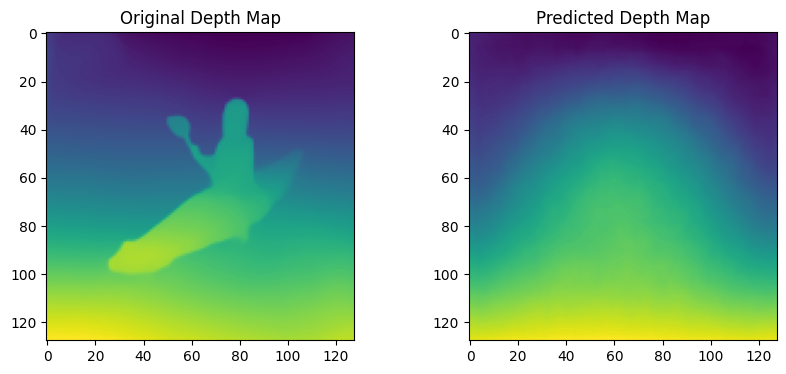

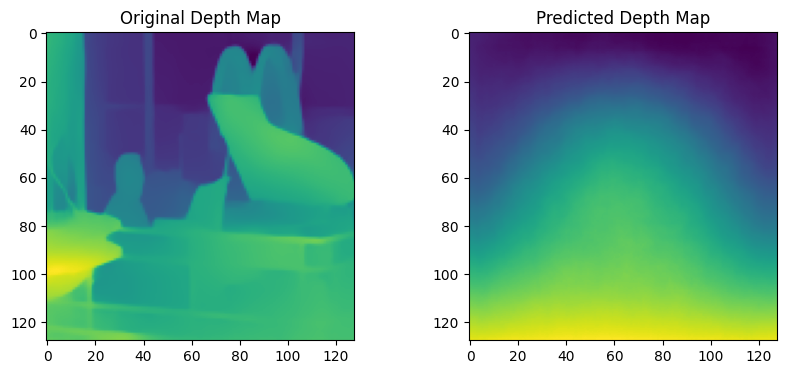

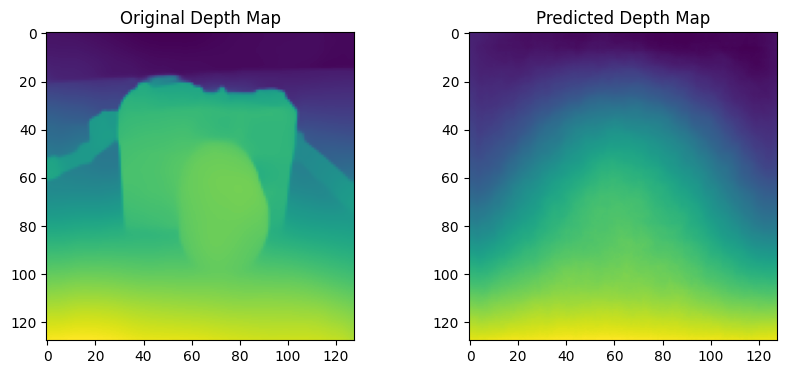

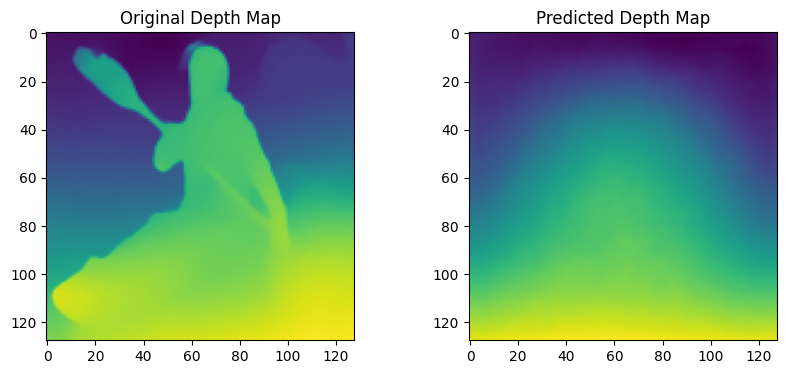

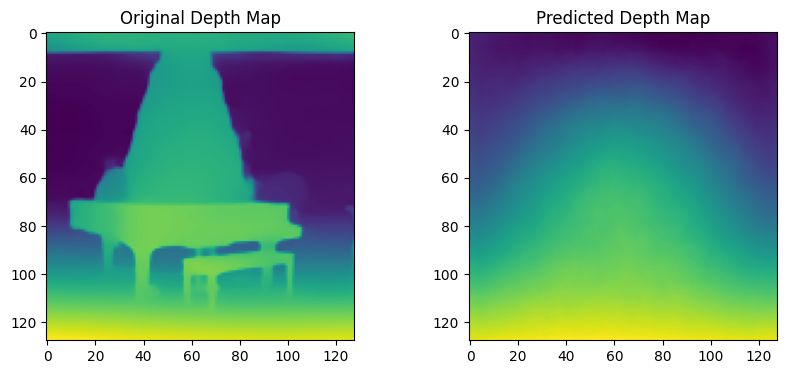

In [50]:
'''import matplotlib.pyplot as plt

def visualize_predictions(model, val_loader, device, num_samples=5):
    model.eval()
    samples = 0
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = model(data)
            for i in range(data.y.size(0)):
                if samples >= num_samples:
                    return
                plt.figure(figsize=(10, 4))
                
                # Original depth map
                plt.subplot(1, 2, 1)
                plt.imshow(data.y[i].squeeze().cpu().numpy(), cmap='viridis')
                plt.title('Original Depth Map')
                
                # Predicted depth map
                plt.subplot(1, 2, 2)
                plt.imshow(output[i].squeeze().cpu().numpy(), cmap='viridis')
                plt.title('Predicted Depth Map')
                
                plt.show()
                samples += 1

# Visualize predictions
visualize_predictions(model, val_loader, device)'''

In [51]:
# import torch
# import torch.nn.functional as F
# import torchvision.transforms as T
# import cv2
# import numpy as np
# from torch_geometric.data import Data, Dataset, DataLoader
# from torch_geometric.nn import GCNConv, global_mean_pool
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# # File paths
# process_file_pth = "/kaggle/input/main-dla-mae-saliency/eeg_5_95_std.pth"
# split_path = "/kaggle/input/main-dla-mae-saliency/block_splits_by_image_single.pth"
# imgNet_path = "/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images"

# # Load data
# try:
#     loaded_data_new = torch.load(process_file_pth)
# except FileNotFoundError:
#     print(f"The file {process_file_pth} does not exist.")
#     loaded_data_new = None
# except Exception as e:
#     print(f"An error occurred: {e}")
#     loaded_data_new = None

# if loaded_data_new:
#     splits = loaded_data_new.keys()
#     print(splits)

#     dataset_new = loaded_data_new["dataset"]
#     labels_new = loaded_data_new["labels"]
#     images_new = loaded_data_new["images"]

#     dataset_new = np.array(dataset_new)
#     labels_new = np.array(labels_new)
#     images_new = np.array(images_new)

#     dataset_image = [dataset_new[i]["image"] for i in range(len(dataset_new))]
#     dataset_label = [dataset_new[i]["label"] for i in range(len(dataset_new))]
#     dataset_eeg = [dataset_new[i]["eeg"] for i in range(len(dataset_new))]
#     dataset_subject = [dataset_new[i]["subject"] for i in range(len(dataset_new))]

#     dataset_corresponding_image = [images_new[value] for value in dataset_image]
#     dataset_corresponding_image = np.array(dataset_corresponding_image)

#     image_paths = [
#         imgNet_path + "/" + img.split("_")[0] + "/" + str(img) + ".JPEG" for img in dataset_corresponding_image
#     ]

#     eeg_list = [eeg[:, 20:470] for eeg in dataset_eeg]
#     print(dataset_eeg[0].shape)

#     channels = [
#         # List of channel names
#     ]

#     # Get the indices of the occipital channels
#     occipital_indices = [i for i, ch in enumerate(channels) if "O" in ch]

#     # Load MiDaS model
#     midas = torch.hub.load('intel-isl/MiDaS', 'MiDaS')
#     midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms').default_transform

#     midas.eval()
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     midas.to(device)

#     def generate_depth_map(image_path):
#         try:
#             img = cv2.imread(image_path)
#             if img is None:
#                 return None

#             img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             input_batch = midas_transforms(img_rgb).to(device)

#             with torch.no_grad():
#                 prediction = midas(input_batch)

#                 prediction = F.interpolate(
#                     prediction.unsqueeze(1),
#                     size=img_rgb.shape[:2],
#                     mode='bicubic',
#                     align_corners=False
#                 ).squeeze()

#             depth_map = prediction.cpu().numpy()
#             depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min() + 1e-8)
#             depth_map_resized = cv2.resize(depth_map, (128, 128), interpolation=cv2.INTER_AREA)

#             return depth_map_resized
#         except Exception as e:
#             print(f"Error processing image {image_path}: {e}")
#             return None

#     def generate_fully_connected_edge_index(num_nodes):
#         row = np.repeat(np.arange(num_nodes), num_nodes)
#         col = np.tile(np.arange(num_nodes), num_nodes)
#         edge_index = np.stack([row, col], axis=0)
#         return torch.tensor(edge_index, dtype=torch.long)

#     class EEGDepthDataset(Dataset):
#         def __init__(self, eegs, image_paths, transform=None):
#             self.eegs = eegs
#             self.image_paths = image_paths
#             self.transform = transform
#             self.skip_path = "/kaggle/input/main-dla-mae-saliency/imageNet_images/imageNet_images/n03452741/n03452741_17620.JPEG"

#         def __len__(self):
#             return len(self.eegs)

#         def __getitem__(self, idx):
#             eeg = self.eegs[idx]
#             img_path = self.image_paths[idx]

#             if img_path == self.skip_path:
#                 print(f"Skipping predefined corrupted image: {img_path}")
#                 return None

#             try:
#                 occipital_eeg = eeg[occipital_indices, :].clone().detach()
#                 depth_map = generate_depth_map(img_path)
#                 if depth_map is None:
#                     return None
#                 depth_map = torch.tensor(depth_map, dtype=torch.float32).unsqueeze(0).clone().detach()

#                 x = occipital_eeg.clone().detach().float()
#                 y = depth_map

#                 edge_index = generate_fully_connected_edge_index(x.shape[0])
#                 data = Data(x=x, edge_index=edge_index, y=y)

#                 return data
#             except Exception as e:
#                 print(f"Skipping corrupted image: {img_path}, Error: {e}")
#                 return None

#     def filter_none_entries(dataset):
#         return [item for item in dataset if item is not None]

#     eegs_train, eegs_val, imgs_train, imgs_val = train_test_split(eeg_list, image_paths, test_size=0.2, random_state=42)

#     train_dataset = EEGDepthDataset(eegs_train, imgs_train)
#     val_dataset = EEGDepthDataset(eegs_val, imgs_val)

#     train_data = filter_none_entries([train_dataset[i] for i in range(len(train_dataset))])
#     val_data = filter_none_entries([val_dataset[i] for i in range(len(val_dataset))])

#     train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
#     val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

#     train_loader = tqdm(train_loader, desc="Training Data Loader")
#     val_loader = tqdm(val_loader, desc="Validation Data Loader")

#     class ImprovedGCNN(torch.nn.Module):
#         def __init__(self, in_channels, hidden_channels, out_channels):
#             super(ImprovedGCNN, self).__init__()
#             self.conv1 = GCNConv(in_channels, hidden_channels)
#             self.conv2 = GCNConv(hidden_channels, hidden_channels)
#             self.conv3 = GCNConv(hidden_channels, hidden_channels)
#             self.fc1 = torch.nn.Linear(hidden_channels, hidden_channels)
#             self.fc2 = torch.nn.Linear(hidden_channels, out_channels)
#             self.dropout = torch.nn.Dropout(0.5)
#             self.batch_norm1 = torch.nn.BatchNorm1d(hidden_channels)
#             self.batch_norm2 = torch.nn.BatchNorm1d(hidden_channels)

#         def forward(self, data):
#             x, edge_index, batch = data.x, data.edge_index, data.batch
#             x = self.conv1(x, edge_index)
#             x = self.batch_norm1(x)
#             x = F.relu(x)
#             x = self.dropout(x)

#             x = self.conv2(x, edge_index)
#             x = self.batch_norm2(x)
#             x = F.relu(x)
#             x = self.dropout(x)

#             x = self.conv3(x, edge_index)
#             x = F.relu(x)
#             x = global_mean_pool(x, batch)

#             x = self.fc1(x)
#             x = F.relu(x)
#             x = self.dropout(x)
#             x = self.fc2(x)

#             return x

#     model = ImprovedGCNN(in_channels=23, hidden_channels=64, out_channels=128*128).to(device)
#     criterion = torch.nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

#     def train(model, train_loader, criterion, optimizer, device, epoch):
#         model.train()
#         total_loss = 0
#         for data in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
#             if data is None:
#                 continue
#             data = data.to(device)
#             optimizer.zero_grad()
#             output = model(data)
#             loss = criterion(output, data.y)
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
#         return total_loss / len(train_loader)

#     def evaluate(model, val_loader, criterion, device):
#         model.eval()
#         total_loss = 0
#         with torch.no_grad():
#             for data in tqdm(val_loader, desc="Evaluating", leave=False):
#                 if data is None:
#                     continue
#                 data = data.to(device)
#                 output = model(data)
#                 loss = criterion(output, data.y)
#                 total_loss += loss.item()
#         return total_loss / len(val_loader)

#     num_epochs = 500
#     patience = 10
#     best_val_loss = float('inf')
#     patience_counter = 0

#     with tqdm(total=num_epochs, desc="Training") as epoch_pbar:
#         for epoch in range(num_epochs):
#             train_loss = train(model, train_loader, criterion, optimizer, device, epoch)
#             val_loss = evaluate(model, val_loader, criterion, device)

#             epoch_pbar.set_postfix({'Train Loss': train_loss, 'Val Loss': val_loss})
#             epoch_pbar.update(1)

#             print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

#             if val_loss < best_val_loss:
#                 best_val_loss = val_loss
#                 patience_counter = 0
#                 torch.save(model.state_dict(), 'best_model.pth')
#             else:
#                 patience_counter += 1
#                 if patience_counter >= patience:
#                     print("Early stopping triggered")
#                     break

The file /kaggle/input/main-dla-mae-saliency/eeg_5_95_std.pth does not exist.
